# AtoZ Leftovers

Last December, [WXPN](http://www.xpn.org/) ran a huge multi-week play list,
[XPN A to Z](http://xpn.org/music-artist/xpn-a-z) playing their catalog alphabetically.
At the time, questions about sorting and such prompted me, among others,
to do some analysis like my [AtoZ](AtoZ.ipynb) notebook.
At the time there was speculation about things like songs that were numbers,
or songs that started with punctuation.
Well, the other day they [announced](http://thekey.xpn.org/2017/04/05/xpnatoz/)
a followup, [A to Z Leftovers](http://xpn.org/music-artist/az-leftovers).

So, let's see what we can learn this time.

In [115]:
%matplotlib inline
from IPython.display import display, HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.input').hide();
    } else {
        $('div.input').show();
    }
        code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


## Getting the Data

For starters, we can just screen scrape the [playlist page](http://xpn.org/music-artist/az-leftovers).
Since the list is shorter, it's all inline.

In [107]:

from lxml import html
import requests
import pandas as pd
from datetime import date, datetime, time
import re

timeslots = [(datetime(2017, 4, 7, 19, 0), datetime(2017, 4, 7, 23, 0)),
             (datetime(2017, 4, 8, 10, 0), datetime(2017, 4, 8, 17, 0)),
             (datetime(2017, 4, 9, 12, 0), datetime(2017, 4, 9, 17, 0))]

today = date.today()
date_regex = re.compile("^\d{2}:\d{2}\s")
leftovers = pd.DataFrame(None, columns = ('Title', 'Artist', 'AirTime'))

for slot in timeslots:
    d = slot[0].date()
    if d <= today:
        page = requests.post('http://xpn.org/playlists/xpn-playlist',
                             data={'playlistdate': "%02d-%02d-%04d" % (d.month,
                                                                       d.day,
                                                                       d.year)})
        tree = html.fromstring(page.content)
        tracks = tree.xpath('//h3/a/text()')
        for track in tracks:
                if date_regex.match(track) and track[9:10] != '|':
                    (artist, title) = track[9:].split(' - ', 1)
                    hour = int(track[0:2]) % 12
                    minute = int(track[3:5])
                    if track[6:8] == 'pm': hour += 12
                    air_time = datetime(d.year, d.month, d.day,
                            hour, minute)
                    if slot[0] <= air_time < slot[1]:
                        leftovers = leftovers.append({'Title': title,
                                                      'Artist': artist,
                                                      'AirTime': air_time},
                                                     ignore_index=True)

                                                    
# page = requests.get('http://xpn.org/music-artist/az-leftovers')
# tree = html.fromstring(page.content)
# tracks = tree.xpath('//div[@class="item-page"]//ul/li/text()')
# for track in tracks:
#     (title, artist) = track.split(' - ', 1)
#     leftovers = leftovers.append({'Title': title, 'Artist': artist}, ignore_index=True)



## Data Enrichment

This will improve but for now,
just sort things by time and pull out the first character or the title as a classifier.

In [108]:
leftovers = leftovers.sort_values(by = ('AirTime'))
leftovers = leftovers.join(leftovers.apply(lambda x: x[0][0].upper(), axis=1).to_frame('First Character'))

## Examining the data

Let's look at a few rows and get soe stats,
just so we know we're working ok.

In [109]:
HTML(leftovers.head(5).to_html())

,Title,Artist,AirTime,First Character
51,#1 Crush,Garbage,2017-04-07 19:02:00,#
50,#1 Hit Song,Minutemen,2017-04-07 19:06:00,#
49,#34,Dave Matthews Band,2017-04-07 19:11:00,#
48,#41,Dave Matthews Band,2017-04-07 19:16:00,#
47,#9 Dream,John Lennon,2017-04-07 19:24:00,#


In [110]:
HTML(leftovers.describe().to_html())

,Title,Artist,AirTime,First Character
count,148,148,148,148
unique,138,126,147,7
top,(I Know) I'm Losing You,Radiohead,2017-04-08 13:45:00,(
freq,3,3,2,67
first,NaN,NaN,2017-04-07 19:02:00,NaN
last,NaN,NaN,2017-04-08 16:56:00,NaN


## First Characters of Titles

That these are non-alphabetic is how we got here.
At this point, on Saturday morning, the list has been pretty parenthesis heavy.
(At least it was until I started working on this bit.)
So, it's not clear yet how to best look a this,
but we'll take a swing at it.

First, just bucket by first character.

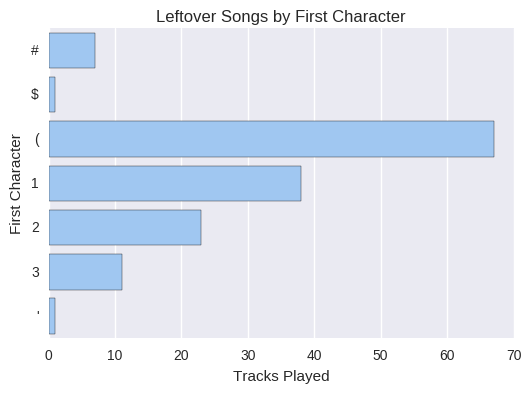

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(6, 4))
sns.set_color_codes('pastel')
sns.countplot(y='First Character', data=leftovers, color='b')
ax.set(xlabel="Tracks Played")
ax.set_title('Leftover Songs by First Character')

Then breakdown the parentheticals by first word.
Honestly, I'm not sure it's all that interesting.

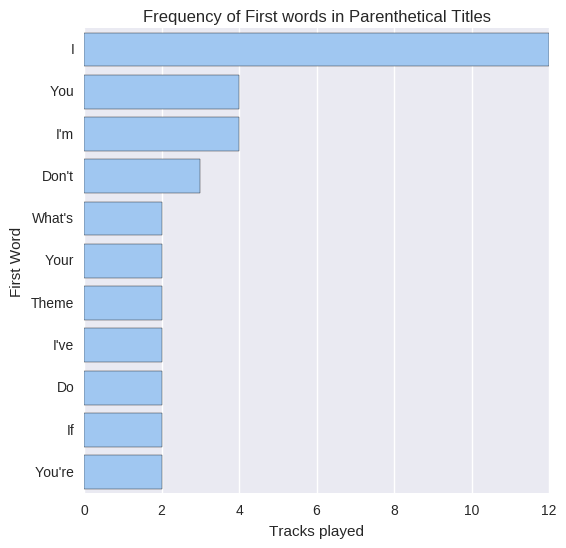

In [112]:
paran_words = leftovers[leftovers['Title'].str.startswith('(')]['Title'].str.extract('([\w\']+)').value_counts()
paran_word_freq = pd.DataFrame(zip(paran_words.keys().tolist(), paran_words.tolist()),
                               columns=('First Word', 'Count'))
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(y='First Word', x='Count', data=paran_word_freq[paran_word_freq['Count'] > 1],
           orient='h', color='b')
ax.set(xlabel='Tracks played')
ax.set_title('Frequency of First words in Parenthetical Titles')
                               


## Popular numbers

Not sure how much useful information there is in numeric song titles,
but we can look for popular numbers.

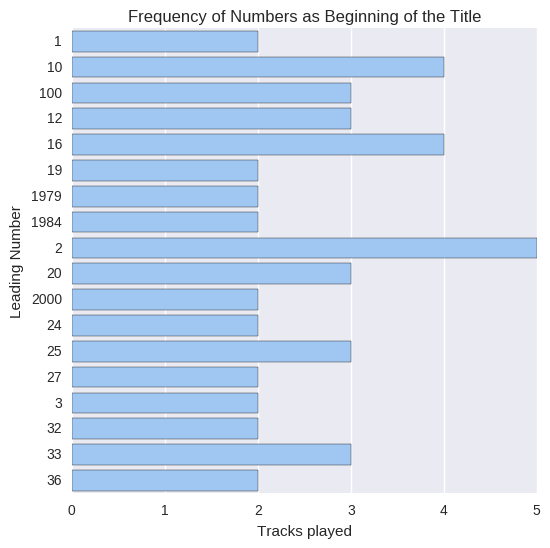

In [113]:
number_counts = leftovers[leftovers['Title'].str.match('^\d')]['Title'].str.extract('(\d+)').value_counts()
number_freq = pd.DataFrame(zip(number_counts.keys().tolist(), number_counts.tolist()),
                          columns=('Leading Number', 'Count'))
number_freq = number_freq.sort_values(by = 'Count')
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(y='Leading Number', x='Count', data=number_freq[number_freq['Count'] > 1],
           orient='h', color='b')
ax.set(xlabel='Tracks played')
ax.set_title('Frequency of Numbers as Beginning of the Title')

##  Breakdown by Artist

In the original playlist, the Beatles dominated the counts.
But in the leftovers, not so much.

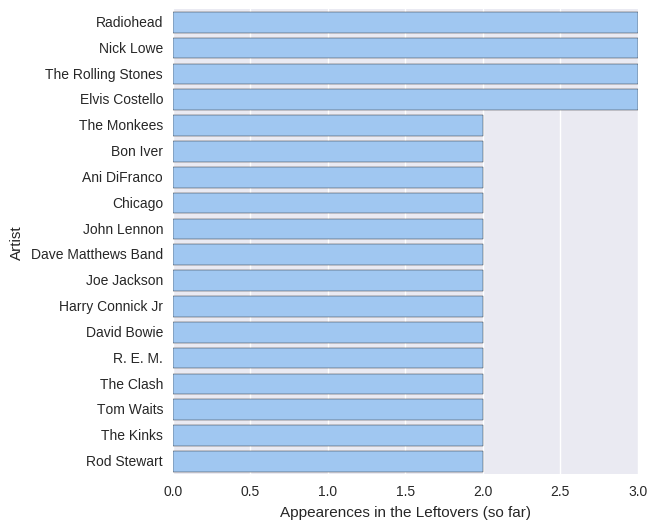

In [114]:
c = leftovers['Artist'].value_counts()
artists = pd.DataFrame(zip(c.keys().tolist(), c.tolist()),
                       columns=('Artist', 'count'))
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes('pastel')
sns.barplot(y='Artist', x='count', data=artists[artists['count'] > 1], color='b')
ax.set(xlabel="Appearences in the Leftovers (so far)")